# C1 W1 Group 8

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import seaborn as sns
import pandas as pd
import cv2

from src.data import GT_QSD1_W2_LIST
from src.paths import BBDD_PATH, QSD1_W2_PATH, QSD2_W2_PATH, QST1_W2_PATH, QST2_W2_PATH, WEEK_2_RESULTS_PATH
from src.descriptors import GreyScaleHistogramDescriptor1D, ColorHistogramDescriptor1D, MultiColorSpaceHistogramDescriptor1D
from src.similarities import MSE, L1Distance, ChiSquaredDistance, HistogramIntersection, HellingerKernel, Bhattacharyya
from src.metrics import MeanAveragePrecisionAtK
import pickle
from tqdm import tqdm

## Task 3 - 
For each image in the QS2, remove background using the background color:
- Create a binary mask to evaluate the method
- Compute the descriptors on the foreground pixels

In [46]:
query_image_PIL_list = [Image.open(db_img_path) for db_img_path in sorted(QSD2_W2_PATH.glob("*.jpg"))]  # Load once
for idx, db_img in enumerate(query_image_PIL_list):
    assert db_img.filename.endswith(f"{idx}.jpg")

GT_image_PIL_list = [Image.open(db_img_path) for db_img_path in sorted(QSD2_W2_PATH.glob("*.png"))]  # Load once
for idx, db_img in enumerate(GT_image_PIL_list):
    assert db_img.filename.endswith(f"{idx}.png")

In [41]:
def find_best_threshold(set1: np.ndarray, set2: np.ndarray) -> tuple[int, int]:
    combined = np.sort(np.concatenate((set1, set2)))
    thresholds = (combined[:-1] + combined[1:]) / 2
    counts1 = np.searchsorted(combined, thresholds, side='right')
    counts2 = len(set2) - counts1
    means = np.mean(set1), np.mean(set2)
    
    scores = np.abs((means[0] * counts1 + means[1] * counts2) / (counts1 + counts2) - 
                    (means[0] * counts2 + means[1] * counts1) / (counts1 + counts2))
    
    best_threshold = int(thresholds[np.argmax(scores)])
    
    if means[1] < means[0]:  
        return best_threshold, 255  
    else:
        return 0, best_threshold

In [44]:
def generate_mask(PIL_img: Image.Image) -> np.ndarray:
    image_np = np.array(PIL_img)
    hsv_image = cv2.cvtColor(image_np,cv2.COLOR_RGB2HSV)

    border_size = 10

    borders = [
        hsv_image[:border_size, :, :], 
        hsv_image[-border_size:, :, :], 
        hsv_image[:, :border_size, :], 
        hsv_image[:, -border_size:, :] 
    ]
    border_pixels = np.vstack([border.reshape(-1, 3) for border in borders])

    img_without_10 = hsv_image[10:-10,10:-10,:].reshape(-1, 3)

    s_thresh = find_best_threshold(img_without_10[:,1],border_pixels[:,1])
    v_thresh = find_best_threshold(img_without_10[:,2],border_pixels[:,2])

    s_mask = cv2.bitwise_and(
        (hsv_image[:, :, 1] > s_thresh[0]).astype(np.uint8),
        (hsv_image[:, :, 1] < s_thresh[1]).astype(np.uint8)
    ).astype(float)

    v_mask = cv2.bitwise_and(
        (hsv_image[:, :, 2] > v_thresh[0]).astype(np.uint8),
        (hsv_image[:, :, 2] < v_thresh[1]).astype(np.uint8)
    ).astype(float)

    mask = cv2.bitwise_or(s_mask,v_mask).astype(float)

    return mask


In [38]:
masks = [generate_mask(img) for img in query_image_PIL_list]

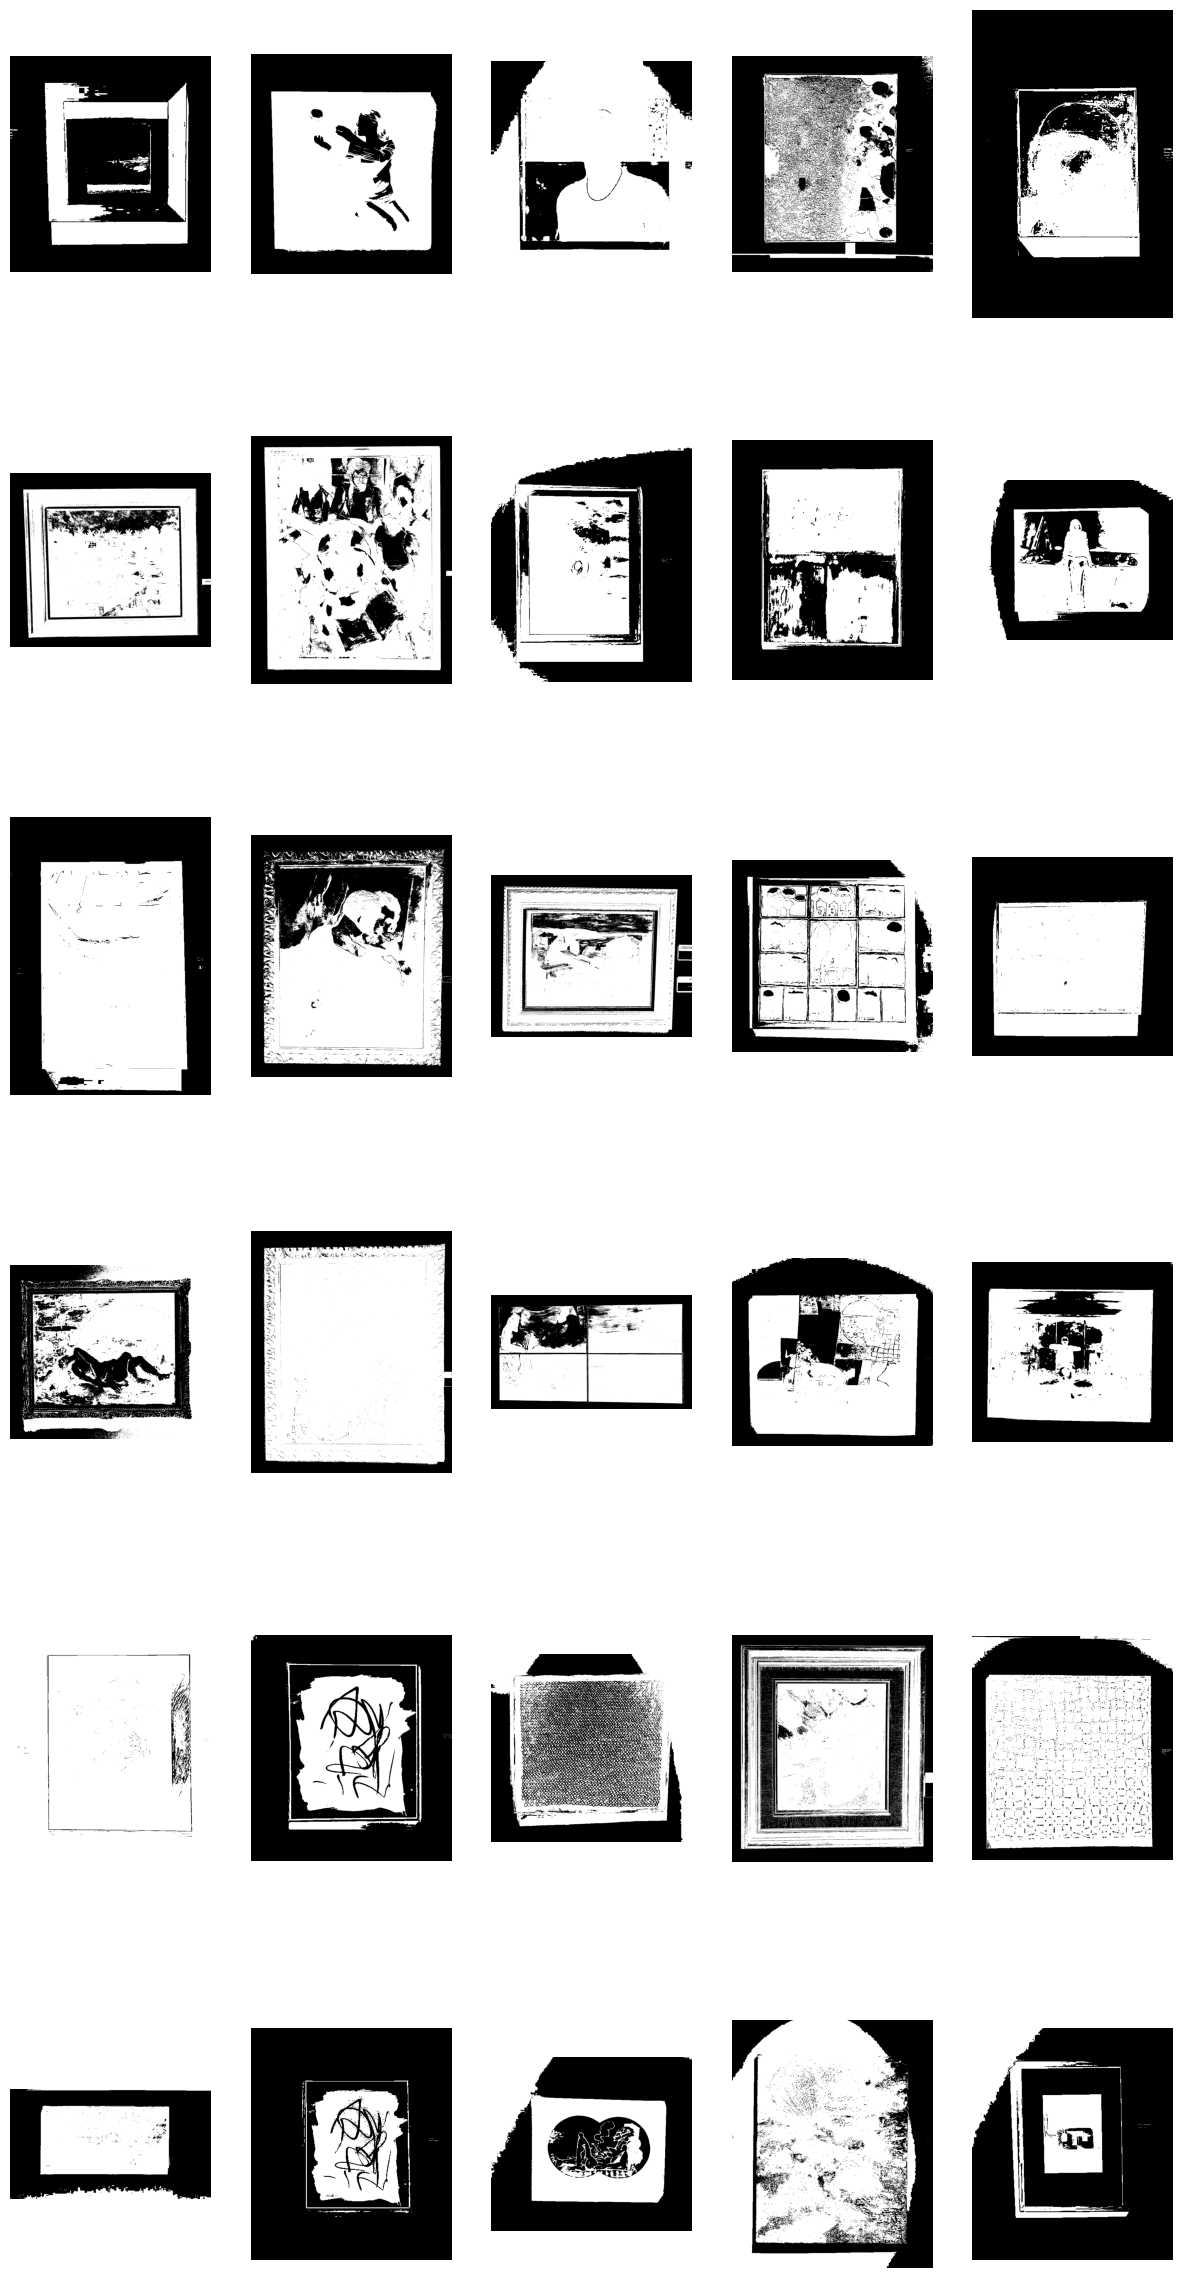

In [43]:
num_masks = len(masks)
cols = 5
rows = (num_masks + cols - 1) // cols 

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for ax in axes:
    ax.axis('off')

for idx, mask in enumerate(masks):
    axes[idx].imshow(mask, cmap='gray')

plt.show()


Calculate score

In [50]:
def calculate_metrics(image1, image2):

    assert np.array_equal(np.unique(image1), [0, 1]), "image1 should be binary."
    assert np.array_equal(np.unique(image2), [0, 1]), "image2 should be binary."

    true_positives = np.sum((image1 == 1) & (image2 == 1))
    false_positives = np.sum((image1 == 1) & (image2 == 0))
    false_negatives = np.sum((image1 == 0) & (image2 == 1))

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

def evaluate_images(mask, mask_GT):
    results = []
    
    for gt_image, query_image in zip(mask_GT, mask):
        gt_array = np.array(gt_image)
        query_array = np.array(query_image)
        
        gt_array = (gt_array > 0).astype(int)  # Convert to binary (0,1)
        query_array = (query_array > 0).astype(int)  # Convert to binary (0,1)
        
        precision, recall, f1_score = calculate_metrics(gt_array, query_array)
        results.append((precision, recall, f1_score))
        
    return results

results = evaluate_images(GT_image_PIL_list, masks)

for i, (precision, recall, f1) in enumerate(results):
    print(f"Image {i + 1}: Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

mean_precision, mean_recall, mean_f1 = np.mean(np.array(results), axis=0)

print(f"Mean Precision: {mean_precision:.2f}, Mean Recall: {mean_recall:.2f}, Mean F1 Score: {mean_f1:.2f}")

Image 1: Precision: 0.72, Recall: 0.41, F1 Score: 0.52
Image 2: Precision: 0.98, Recall: 0.90, F1 Score: 0.94
Image 3: Precision: 0.55, Recall: 0.81, F1 Score: 0.66
Image 4: Precision: 0.94, Recall: 0.69, F1 Score: 0.80
Image 5: Precision: 0.85, Recall: 0.68, F1 Score: 0.76
Image 6: Precision: 0.99, Recall: 0.85, F1 Score: 0.92
Image 7: Precision: 0.99, Recall: 0.80, F1 Score: 0.89
Image 8: Precision: 0.62, Recall: 0.77, F1 Score: 0.69
Image 9: Precision: 0.99, Recall: 0.74, F1 Score: 0.85
Image 10: Precision: 0.64, Recall: 0.75, F1 Score: 0.69
Image 11: Precision: 0.92, Recall: 0.99, F1 Score: 0.95
Image 12: Precision: 1.00, Recall: 0.71, F1 Score: 0.83
Image 13: Precision: 0.97, Recall: 0.82, F1 Score: 0.89
Image 14: Precision: 0.82, Recall: 0.81, F1 Score: 0.82
Image 15: Precision: 0.83, Recall: 0.96, F1 Score: 0.89
Image 16: Precision: 0.65, Recall: 0.55, F1 Score: 0.60
Image 17: Precision: 0.99, Recall: 0.98, F1 Score: 0.98
Image 18: Precision: 1.00, Recall: 0.81, F1 Score: 0.89
I